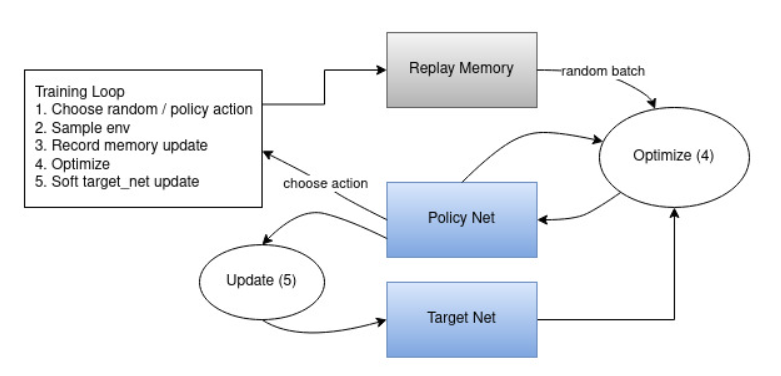

In [10]:
from itertools import count

import gym
import matplotlib
import matplotlib.pyplot as plt
import torch
from cartpole_qnet import DEVICE, TAU, DQNAgent

In [11]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [12]:
# Load the model
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

In [ ]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


num_episodes = 600 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50

for _i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    for t in count():
        action = agent.select_action(state, env)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=DEVICE).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.update_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[
                key
            ] * (1 - TAU)
        agent.target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()